In [1]:
%matplotlib inline

import holidays

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rpy2.robjects as robjects

from rpy2.robjects import pandas2ri
from pandas.tseries.holiday import Holiday, AbstractHolidayCalendar
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.externals import joblib

pandas2ri.activate()
R = robjects.r
plt.style.use('ggplot')

### Load data

In [27]:
def flag_holidays(data):
    # Flag Holidays
    df = data.copy()
    df['isHoliday'] = pd.Series(df.index.date).isin(holidays.France(years=np.unique(df.index.year))).values
    return df
        
    
def load_data(nrows=None, colnames=['datetime', 'value'], generate=False):

    if generate:
        nrows = nrows or 1e4
        df = pd.DataFrame({
            'value': np.random.rand(int(nrows)), 
            'datetime': pd.date_range(start='1970-01-01', freq='10T', tz='UTC', periods=nrows)
        })
        df = df.set_index('datetime')     
    else:
        df = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/flights.csv')
        df['datetime'] = pd.to_datetime(
            df.apply(lambda x: "{}/{}/01".format(x['year'], x['month']), axis=1), 
            format="%Y/%B/%d")

        df = df.set_index('datetime').tz_localize('UTC').drop(['year', 'month'], axis=1)
        df.columns = ['value']
        df = df.resample('H').interpolate('linear')          
        
    # Flag Holidays
    df = flag_holidays(df)
                
    # Extract date components
    df['time_wday'] = df.index.weekday + 1
    df['time_mday'] = df.index.day
    df['time_month'] = df.index.month
    df['time_hour'] = df.index.hour
    
    # Flag Weekends
    df['isWeekend'] = np.array((df['time_wday'] >= 6)).astype(int)

    return df

In [28]:
def create_forecast_set(df, horizon=365*1440, period_in_minutes = 10):
    
    time_from = df["time"].sort_values().tail(1).iloc[0] + period_in_minutes * pd.tseries.offsets.Minute()
    time_to = time_from + horizon * pd.tseries.offsets.Minute()
    df = pd.DataFrame({'time' : pd.date_range(time_from, time_to, freq=str(period_in_minutes)+'T')})
    
    df['value'] = 0
    
    # Read and clean
    df = df.set_index(['time']).sort_index()
    df = df[np.invert(df.index.to_series().isnull())]
    df = df.reset_index().set_index('time')               
    
    # Extract date components
    df['time_wday'] = df.index.weekday+1
    df['time_mday'] = df.index.day
    df['time_month'] = df.index.month
    df['time_hour'] = df.index.hour
         
    # Flag Holidays
    df = flag_holidays(df)
    
    # Flag Weekends
    df['isWeekend'] = np.array((df['time_wday'] >= 6)).astype(int)
    
    df.drop(['value'], axis=1, inplace=True)
    
    # Output datasets
    return df


### Define the model

In [29]:
def get_regressor_for_input_prepared(data, show_plot=False, verbose=True, warm_start=False, model_name='model'):

    
    # #### Importing base data
    
    # The first step is to get our machine learning dataset:
    ml_dataset = data.copy()
    
    # We apply the preparation that you defined. You should not modify this.
    if verbose:
        print('[get_regressor_for_input_prepared] Base data has %i rows and %i columns' % (ml_dataset.shape[0], ml_dataset.shape[1]))
    
    # #### Initial data management
    
    # The preprocessing aims at making the dataset compatible with modeling.
    # At the end of this step, we will have a matrix of float numbers, with no missing values.
    # We'll use the features and the preprocessing steps defined in Models.
    # 
    # Let's only keep selected features
    
    ml_dataset = ml_dataset[['value', 'time_wday', 'time_mday', 'time_month', 'time_hour', 'isHoliday', 'isWeekend']]
    
    
    # Let's first coerce categorical columns into str, numerical features into floats.
    
    categorical_features = []
    numerical_features = ['time_wday', 'time_mday', 'time_month', 'time_hour', 'isHoliday', 'isWeekend']
    text_features = []
    #from dataiku.doctor.utils import datetime_to_epoch
    for feature in categorical_features:
        ml_dataset[feature] = ml_dataset[feature].astype(str)
    for feature in text_features:
        ml_dataset[feature] = ml_dataset[feature].astype(str)
    for feature in numerical_features:
        if ml_dataset[feature].dtype == np.dtype('M8[ns]'):
            ml_dataset[feature] = ml_dataset[feature].astype(int)/10**9
        else:
            ml_dataset[feature] = ml_dataset[feature].astype('double')
    
    
    # We renamed the target variable to a column named target
    ml_dataset['__target__'] = ml_dataset['value']
    del ml_dataset['value']
    
    # Remove rows for which the target is unknown.
    ml_dataset = ml_dataset[~ml_dataset['__target__'].isnull()]
    
    # #### Cross-validation strategy
    
    # The dataset needs to be split into 2 new sets, one that will be used for training the model (train set)
    # and another that will be used to test its generalization capability (test set)
    
    # Important note: your model used a more advanced cross-validation strategy.
    # For the purpose of this notebook, it has been simplified to a random split of
    # a single dataset
    
    #train, test = pdu.split_train_valid(ml_dataset, prop=0.8)
    if warm_start:
        train = ml_dataset.sample(frac=0.8)
        test = pd.DataFrame(columns=train.columns)
    else:
        train = ml_dataset.sample(frac=0.8)
        test = ml_dataset[~ml_dataset.index.isin(train.index)]
    
    if verbose:
        print('[get_regressor_for_input_prepared] Train data has %i rows and %i columns' % (train.shape[0], train.shape[1]))
        print('[get_regressor_for_input_prepared] Test data has %i rows and %i columns' % (test.shape[0], test.shape[1]))
    
    
    # #### Features preprocessing
    
    # The first thing to do at the features level is to handle the missing values.
    # Let's reuse the settings defined in the model
    
    drop_rows_when_missing = []
    impute_when_missing = [{'impute_with': u'PAD', 'feature': u'time_wday'}, 
                           {'impute_with': u'PAD', 'feature': u'time_mday'}, 
                           {'impute_with': u'PAD', 'feature': u'time_month'}, 
                           {'impute_with': u'PAD', 'feature': u'time_hour'}, 
                           {'impute_with': u'PAD', 'feature': u'isHoliday'}, 
                           {'impute_with': u'PAD', 'feature': u'isWeekend'}]
    
    # Features for which we drop rows with missing values"
    for feature in drop_rows_when_missing:
        train = train[train[feature].notnull()].copy()
        test = test[test[feature].notnull()].copy()
        if verbose:
            print('[get_regressor_for_input_prepared] Dropped missing records in %s' % feature)
    
    # Features for which we impute missing values"
    for feature in impute_when_missing:
        
        if feature['impute_with']=='PAD':
            train.loc[:,feature['feature']] = train[feature['feature']].fillna(method='pad')
            test.loc[:,feature['feature']] = test[feature['feature']].fillna(method='pad') 
            v = 'corresponding to the last observed value'
        elif feature['impute_with']=='INTERPOLATE':
            train.loc[:,feature['feature']] = train[feature['feature']].interpolate()
            test.loc[:,feature['feature']] = test[feature['feature']].interpolate()
            v = 'corresponding to a linear interpolation'
        else:
            if feature['impute_with'] == 'MEAN':
                v = train[feature['feature']].mean()
            elif feature['impute_with'] == 'MEDIAN':
                v = train[feature['feature']].median()
            elif feature['impute_with'] == 'CREATE_CATEGORY':
                v = np.NaN
            elif feature['impute_with'] == 'MODE':
                v = train[feature['feature']].value_counts().index[0]
            train.loc[:, feature['feature']] = train[feature['feature']].fillna(v)
            test.loc[:,feature['feature']] = test[feature['feature']].fillna(v)
        if verbose:
            print('[get_regressor_for_input_prepared] Imputed missing values in feature %s with value %s' % (feature['feature'], str(v)))
    
    if warm_start:
        # Load regressor and rescaler from pickle
        regressor, preprocessing_rescaler = joblib.load("./{}.pkl".format(model_name))
        
        # Re-scaling        
        if verbose: print("[get_regressor_for_input_prepared] Using calculated scaler")
        for feature_name, scaler in preprocessing_rescaler.items():
            train.loc[:, feature_name] = scaler.transform(train[feature_name])
            test.loc[:, feature_name] = scaler.transform(test[feature_name])
            
        # #### Modeling       
        if verbose: print("[get_regressor_for_input_prepared] Using trained model. {} estimators were trained before, 100 new estimators will be trained".format(regressor.n_estimators))
        regressor.set_params(n_estimators=regressor.n_estimators + 100, warm_start=True, oob_score=False)  
        
    else:
        # Recalculate preprocessing rescalereverithing
        if verbose: print("[get_regressor_for_input_prepared] Recalculate scaler")

        # We can now handle the categorical features (still using the settings defined in Models):
        
        # Let's rescale numerical features
        rescale_features = {u'time_hour': u'NONE', 
                            u'time_month': u'NONE', 
                            u'time_wday': u'NONE', 
                            u'time_mday': u'NONE',
                            u'isWeekend': u'NONE',
                            u'isHoliday': u'NONE'}
    
        preprocessing_rescaler = {}
        for feature_name, rescale_method in rescale_features.items():
            if rescale_method != 'NONE':
                if rescale_method == 'MINMAX':
                    scaler = MinMaxScaler().fit(train[feature_name])
                elif rescale_method =='AVGSTD':
                    scaler = StandardScaler().fit(train[feature_name])
                if verbose:
                    print('[get_regressor_for_input_prepared] Rescaled %s' % feature_name)
                train.loc[:, feature_name] = scaler.transform(train[feature_name])
                test.loc[:, feature_name] = scaler.transform(test[feature_name])
                
                preprocessing_rescaler.update({feature_name:scaler}) 

        # #### Modeling       
        if verbose: print("[get_regressor_for_input_prepared] Building new model")
        
        from sklearn.ensemble import RandomForestRegressor
        regressor = RandomForestRegressor(n_estimators=100,#84,
                                          n_jobs=4,
                                          random_state=1458,
                                          max_depth=40,
                                          min_samples_leaf=1,
                                          verbose=False,
                                          oob_score=True)
    
    # Before actually creating our model, we need to split the datasets into their features and labels parts:
    train_X = train.drop('__target__', axis=1).copy()
    train_Y = np.array(train['__target__']).copy()
    
    # ... And train it
    regressor.fit(train_X, train_Y)
    
    # Dump model and rescaler to pickle  
    if verbose: print("[get_regressor_for_input_prepared] Saving results to a pkl file")
    joblib.dump((regressor, preprocessing_rescaler), "./{}.pkl".format(model_name))

    # Let's have a look at feature importances
    feature_importances_data = []
    features = train_X.columns
    for feature_name, feature_importance in zip(features, regressor.feature_importances_):
        feature_importances_data.append({
            'feature': feature_name,
            'importance': feature_importance
        })
    
    feature_importances_df = pd.DataFrame(feature_importances_data).set_index('feature').sort_values('importance')
    
    feature_importances_df = pd.DataFrame(feature_importances_data).set_index('feature').sort_values('importance')
    if show_plot:
        feature_importances_df.plot(title='Top 10 most important variables',
                                    kind='barh', figsize=(10, 6), color='#348ABD', alpha=0.6,
                                    lw='1', edgecolor='#348ABD', grid=False,)
                                    
    if warm_start:
        return {'model':regressor, 'scaler':preprocessing_rescaler}
    else:   
        test_X = test.drop('__target__', axis=1)    
        test_Y = np.array(test['__target__'])
        
        # Build up our result dataset
        _predictions = regressor.predict(test_X)
        predictions = pd.Series(data=_predictions, index=test_X.index, name='predicted_value')
        
        # Build scored dataset
        results_test = (test_X.join(predictions, how='left')
                              .join(test['__target__'], how='left')
                              .rename(columns= {'__target__': 'value'}))
        
        c =  results_test[['predicted_value', 'value']].corr()
        if verbose:
            print('[get_regressor_for_input_prepared] Pearson correlation: {} \n'.format(results_test['predicted_value'][1]))
      
        # #### Results
        # You can measure the model's accuracy:
        # Out-Of-Bag accuracy    
        oob_residuals = train_Y - regressor.oob_prediction_
        oob_errors = {'MSE' : np.mean(oob_residuals**2),
                      'MRSE' : np.mean(np.sqrt(oob_residuals**2)),
                      'MAE' : np.mean(abs(oob_residuals)),
                      'MAPE' : np.mean(abs((oob_residuals+1)/(train_Y+1)))}
        
        # Plot the results
        if show_plot:
            results_test[['value', 'predicted_value']].plot()
            results_test.plot(x='value', y='predicted_value', kind='scatter')
        
        return {'model':regressor, 'oob_score' : regressor.oob_score_, 'oob_errors' : oob_errors, 'scaler':preprocessing_rescaler}

### Main

In [30]:
R(
    """
    compute_forecast_volatility <- function(data, sigma_multiplier = 2, verbose=FALSE, warm_start=FALSE){
        library(data.table)
        library(forecast)
        library(rugarch)
        library(zoo)

        data <- as.data.table(data)
        invisible(data[, time := as.POSIXct(as.character(time), format='%Y-%m-%d %H:%M:%S', tz='Europe/Paris')])


        # zoo object
        data_set  <- na.omit(zoo(data[, residuals], data[, time]))
        n <- NROW(data_set)
        desired_outOfSample <- 144*7*8
        outOfSample <- ifelse(n < desired_outOfSample, n-10, desired_outOfSample - 10)

        if (warm_start){
            # Load spec from RData
            load("./arimaGarch_fixed_spec.RData") 
            garch.fit = ugarchfilter(spec_fixed, rbind(old_data_set, data_set), n.old = 100)

            setfixed(spec_fixed) <- as.list(coef(garch.fit))

            # Save spec to RData
            old_data_set <- tail(rbind(old_data_set, data_set), 100)
            save(spec_fixed, old_data_set, file="./arimaGarch_fixed_spec.RData")

        } else {
            # ARIMA + GARCH
            result_arima <- auto.arima(as.vector(data_set))

            spec <- ugarchspec(variance.model=list(model = 'sGARCH', garchOrder = c(1, 1)), 
                               mean.model=list(armaOrder = c(result_arima$arma[1], result_arima$arma[2]), include.mean=result_arima$arma[5]),
                               distribution.model="norm")

            if (verbose) { print('[compute_forecast_volatility] Used model\n'); print(spec)}

            # Normal model
            garch.fit <- ugarchfit(spec=spec, data=data_set, fit.control=list(scale=TRUE))

            # http://quant.stackexchange.com/questions/7932/forecasting-using-rugarch-package
            spec_fixed <- spec
            setfixed(spec_fixed) <- as.list(coef(garch.fit))

            # Save spec to RData
            old_data_set <- tail(data_set, 100)
            save(spec_fixed, old_data_set, file="./arimaGarch_fixed_spec.RData")
        }    

        # Forecast
        garch.forecast <- ugarchforecast(spec_fixed, n.ahead = 1, n.roll = outOfSample, data = data_set, out.sample = outOfSample)

        if (verbose) print(paste('[compute_forecast_volatility] Performance\n', names( fpm(garch.forecast)), fpm(garch.forecast)))

        # Build output data.table
        time_difference <- round(mean(diff(time(data_set))), -1)
        start_date <- end(data_set) + time_difference

        data_result <- data.table(pred  = as.vector(as.vector(fitted(garch.forecast))),
                                  sigma = as.vector(as.vector(sigma(garch.forecast))),
                                  quant_95 = as.vector(quantile(garch.forecast, probs=0.95)),
                                  quant_99 = as.vector(quantile(garch.forecast, probs=0.99)),
                                  quant_75 = as.vector(quantile(garch.forecast, probs=0.75)))

        data_result[, time := seq(from=start_date, by=time_difference, length.out = outOfSample + 1)]


        invisible(data_result[, lwr  := pred - sigma_multiplier*sigma])
        invisible(data_result[, uppr := pred + sigma_multiplier*sigma])

        forecast_volatility <- as.data.frame(data_result)

        if (verbose) print(paste('[compute_forecast_volatility] Computed', outOfSample, 'forecasts from', start_date, 'to', tail(data_result$time,1), '( time-step:', time_difference, ')'))   

        # Output datasets
        return (forecast_volatility)
    }
    """
)

R object with classes: ('function',) mapped to:
<SignatureTranslatedFunction - Python:0x7ff07a7d6788 / R:0xd66d0b8>

In [36]:
warm_start=False
show_plot=True
verbose=True

# prepare input dataframe
input_prepared = load_data(nrows=None, generate=True)

In [37]:
input_prepared.head()

,value,isHoliday,time_wday,time_mday,time_month,time_hour,isWeekend
datetime,,,,,,,
1970-01-01 00:00:00+00:00,0.944532,True,4,1,1,0,0
1970-01-01 00:10:00+00:00,0.533386,True,4,1,1,0,0
1970-01-01 00:20:00+00:00,0.630785,True,4,1,1,0,0
1970-01-01 00:30:00+00:00,0.214313,True,4,1,1,0,0
1970-01-01 00:40:00+00:00,0.287744,True,4,1,1,0,0


[get_regressor_for_input_prepared] Base data has 10000 rows and 7 columns
[get_regressor_for_input_prepared] Train data has 8000 rows and 7 columns
[get_regressor_for_input_prepared] Test data has 2000 rows and 7 columns
[get_regressor_for_input_prepared] Imputed missing values in feature time_wday with value corresponding to the last observed value
[get_regressor_for_input_prepared] Imputed missing values in feature time_mday with value corresponding to the last observed value


/home/jose.lopez/workspace/python_virtualenvs/development/lib/python3.5/site-packages/pandas/core/indexing.py:601: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


[get_regressor_for_input_prepared] Imputed missing values in feature time_month with value corresponding to the last observed value
[get_regressor_for_input_prepared] Imputed missing values in feature time_hour with value corresponding to the last observed value
[get_regressor_for_input_prepared] Imputed missing values in feature isHoliday with value corresponding to the last observed value
[get_regressor_for_input_prepared] Imputed missing values in feature isWeekend with value corresponding to the last observed value
[get_regressor_for_input_prepared] Recalculate scaler
[get_regressor_for_input_prepared] Building new model
[get_regressor_for_input_prepared] Saving results to a pkl file
[get_regressor_for_input_prepared] Pearson correlation: 0.6652975064667617 



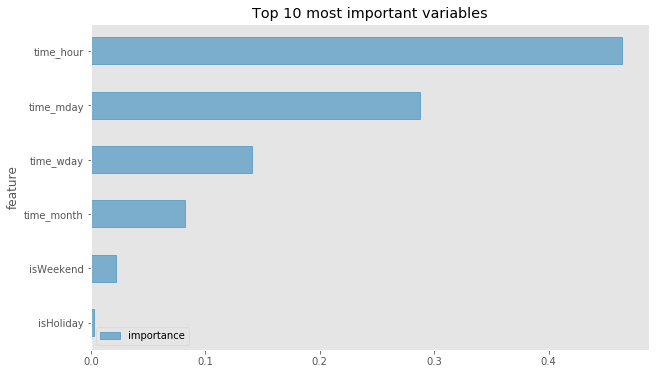

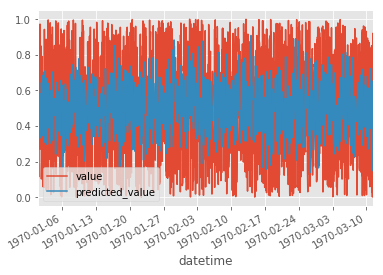

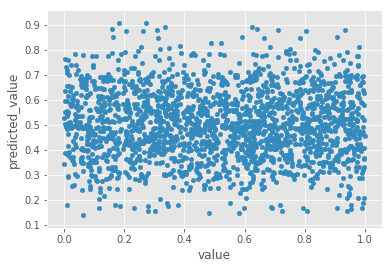

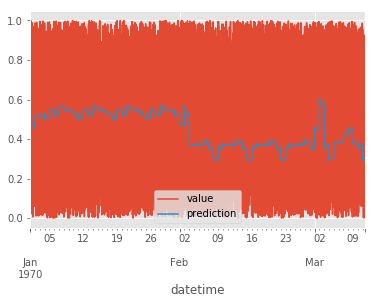

In [38]:
# Train and deploy model
result_analysis = get_regressor_for_input_prepared(input_prepared, show_plot=show_plot, verbose=verbose, warm_start=warm_start)

# Rescale input dataframe
_tmp = input_prepared.copy()
for feature_name, scaler in result_analysis['scaler'].items():
    if verbose: print('[main_thread] Rescaled %s' % feature_name)
    _tmp.loc[:, feature_name] = scaler.transform(_tmp[feature_name])    

# Apply model to rescaled input dataframe
predictions = pd.Series(data=result_analysis['model'].predict(_tmp.dropna().drop('value', axis=1)),
                                  index=_tmp.dropna().index, name='prediction')
regressor = result_analysis['model']

input_prepared_scored = input_prepared.join(predictions, how='left')

if show_plot: input_prepared_scored[['value', 'prediction']].plot()

# Calculate residuals for the volatility
input_prepared_scored['residuals'] = input_prepared_scored.eval('value - prediction')

# Create forecast dataset and predict
forecast_set = create_forecast_set(input_prepared.reset_index().rename(columns={'datetime':'time'}),
                                            horizon=1440*7*8,       # Predict 8 weeks
                                            period_in_minutes = 10) # in 10 minutes steps

In [39]:
forecast_set.head()

,time_wday,time_mday,time_month,time_hour,isHoliday,isWeekend
time,,,,,,
1970-03-11 10:40:00+00:00,3,11,3,10,False,0
1970-03-11 10:50:00+00:00,3,11,3,10,False,0
1970-03-11 11:00:00+00:00,3,11,3,11,False,0
1970-03-11 11:10:00+00:00,3,11,3,11,False,0
1970-03-11 11:20:00+00:00,3,11,3,11,False,0


/home/jose.lopez/workspace/python_virtualenvs/development/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:57: UserWarning: Error while trying to convert the column "time". Fall back to string conversion. The error is: Cannot pass numpy arrays with non-native byte orders at the moment.
  (name, str(e)))


[1]
 "[compute_forecast_volatility] Used model\n"



*---------------------------------*

*       GARCH Model Spec          *

*---------------------------------*


Conditional Variance Dynamics 	

------------------------------------

GARCH Model		: sGARCH(1,1)

Variance Targeting	:
 
FALSE
 



Conditional Mean Dynamics

------------------------------------

Mean Model		: ARFIMA(

1

,

0

,

2

)

Include Mean		:
 
TRUE
 


GARCH-in-Mean		:
 
FALSE
 



Conditional Distribution

------------------------------------

Distribution	: 
 
norm
 


Includes Skew	: 
 
FALSE
 


Includes Shape	: 
 
FALSE
 


Includes Lambda	: 
 
FALSE
 



[1]
 "[compute_forecast_volatility] Performance\n MSE 0.0829027538594823"


[2]
 "[compute_forecast_volatility] Performance\n MAE 0.248195692334152" 


[3]
 "[compute_forecast_volatility] Performance\n DAC 0.59113483983114"  


[1]
 "[compute_forecast_volatility] Computed 8054 forecasts from 1970-03-11 10:40:00 to 1970-05-06 09:00:00 ( time-step: 10 )"




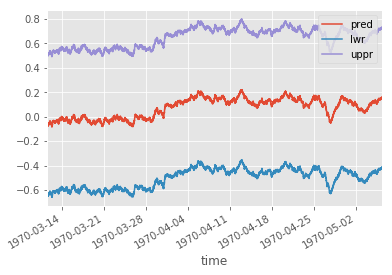

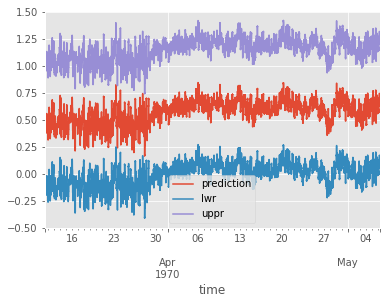

In [40]:
regressor_forecast = pd.Series(data=regressor.predict(forecast_set), index=forecast_set.index, name='prediction')

# del predictions
# del result_analysis
# del input_prepared
# del forecast_set

# Calculate the volatility with ARIMA + GARCH           
_tmp = input_prepared_scored.reset_index().rename(columns={'datetime':'time'})#.head(100)
# del input_prepared_scored

volatility_forecast = R('compute_forecast_volatility')(_tmp, verbose=verbose, warm_start=warm_start)
volatility_forecast = pandas2ri.ri2py_dataframe(volatility_forecast)
volatility_forecast['time'] = volatility_forecast['time'].apply(pd.datetime.fromtimestamp)
volatility_forecast.set_index(['time'], inplace=True)
volatility_forecast.index = volatility_forecast.index.tz_localize('Europe/Paris', ambiguous='NaT')

if show_plot: volatility_forecast[['pred', 'lwr', 'uppr']].plot()

# Merge both forecasts
forecast = pd.merge(regressor_forecast.to_frame(), volatility_forecast[['pred', 'sigma']], how="inner",  left_index=True, right_index=True)
# del volatility_forecast
# del regressor_forecast
forecast.rename(columns={'prediction' : 'regressor_prediction', 'pred' : 'volatility_prediction'}, inplace=True)
forecast['prediction'] = forecast.eval("regressor_prediction + volatility_prediction")
forecast['uppr'] = forecast.eval("prediction + {}*sigma".format(2))
forecast['lwr'] = forecast.eval("prediction - {}*sigma".format(2))

if show_plot: forecast[['prediction', 'lwr', 'uppr']].plot()

#     return forecast

In [41]:
forecast.head()

,regressor_prediction,volatility_prediction,sigma,prediction,uppr,lwr
time,,,,,,
1970-03-11 10:40:00+00:00,0.445660,-0.051260,0.287601,0.394400,0.969602,-0.180802
1970-03-11 10:50:00+00:00,0.445660,-0.056935,0.287630,0.388725,0.963985,-0.186535
1970-03-11 11:00:00+00:00,0.505434,-0.062981,0.287750,0.442453,1.017953,-0.133047
1970-03-11 11:10:00+00:00,0.505434,-0.066922,0.287786,0.438512,1.014084,-0.137061
1970-03-11 11:20:00+00:00,0.505434,-0.062965,0.287763,0.442469,1.017995,-0.133058


In [42]:
out = pd.concat([input_prepared['value'].tail(2000).to_frame(), forecast[["prediction", "uppr", "lwr"]]], axis=0)

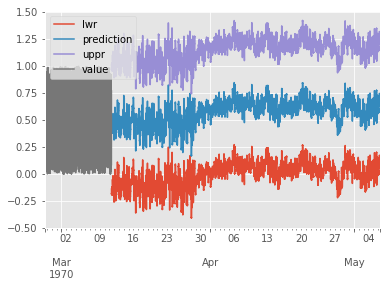

In [43]:
out.plot()